# Imports

In [23]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
random_seed = 123

Here we read in our two .csv files which represent the electricity rates and generation data:

In [24]:
dfr = pd.read_csv('./data/electricity-rates.csv')
dfg = pd.read_csv('./data/electricity-generation.csv')

In [25]:
dfg.drop(columns=['Unnamed: 0'], inplace=True)

# Merging into one DataFrame

Separate preprocessing of rates and generation data is complete. The next step is to merge all the meaningful data into one dataframe. First, we will confirm the two dataframes have the same Year and State order:

In [26]:
dfg['Year'].equals(dfr['Year'])

True

In [27]:
dfr['State'].equals(dfr['State'])

True

The only data we need from the rates dataframe is Cents_kWh. Here we add it to the generation dataframe:

In [28]:
dfg['Cents_kWh'] = dfr['Cents_kWh_Inf_Adj']

In [29]:
dfg.head()

,Year,State,Coal,Geothermal,Hydroelectric,Natural Gas,Nuclear,Other,Other Gases,Petroleum,Solar Thermal/PV,Total,Wind,Biomass,Cents_kWh
0,1990,AK,510573,0,974521,3466261,0,0,0,497116,0,5599506,0,151035,14.17
1,1990,AL,53658115,0,10366507,1020714,12051882,0,269476,138089,0,79652133,0,2147350,8.32
2,1990,AR,19207935,0,3654653,3578573,11282053,0,0,79979,0,39099598,0,1253433,10.01
3,1990,AZ,31915610,0,7417576,2333900,20597689,0,0,151867,0,62774297,0,107888,11.58
4,1990,CA,2637677,14521254,23792567,74168308,32692807,0,2146742,5473852,366668,165784909,2758881,6239901,13.21


## Creating a "Renewables" Column

Each type of renewable energy is relatively small for most of our time period, except hydroelectric, which is the dominant generation source in some states. For clustering, we will likely want to represent renewables as a whole. For our purposes we will include the sum of hydroelectric, geothermal, biomass, solar, and wind in a "Renewables" column. 

In [30]:
dfg['Renewables'] = dfg['Hydroelectric'] + dfg['Geothermal'] + dfg['Biomass'] + dfg['Solar Thermal/PV'] + dfg['Wind']

In [31]:
dfg.tail()

,Year,State,Coal,Geothermal,Hydroelectric,Natural Gas,Nuclear,Other,Other Gases,Petroleum,Solar Thermal/PV,Total,Wind,Biomass,Cents_kWh,Renewables
1474,2018,VT,0,0,1268189,1797,0,-296,0,3132,106740,2178915,373346,426008,11.77,2174283
1475,2018,WA,5382866,0,80883377,10535078,9708441,59265,430840,23656,1695,116756729,7900094,1803179,6.22,90588345
1476,2018,WI,33322379,0,2392010,16798619,10129122,42631,0,137511,39682,65936767,1637658,1437154,8.23,5506504
1477,2018,WV,62038835,0,1847643,1420390,0,-11558,24845,158885,0,67249025,1769984,0,6.78,3617627
1478,2018,WY,39679287,0,975702,896122,0,85266,377641,40136,824,46112136,4057158,0,6.29,5033684


## Reordering and Transposing

Let's reorder our columns such that non-dispatchable are first, dispatchable are second, and intermittent are last. That way when we start plotting, the order of the stack will be meaningful, with non-dispatchable at the bottom of the plot, dispatchable in the middle, and intermittent at the top.

In [32]:
columns = ['Year', 'State', 'Coal', 'Nuclear',  'Petroleum',
           'Natural Gas',  'Other Gases', 'Other', 'Hydroelectric', 'Geothermal', 
           'Biomass', 'Solar Thermal/PV', 'Wind', 'Renewables', 'Total', 'Cents_kWh']
dfg=dfg.reindex(columns=columns)

In [33]:
dfg.head()

,Year,State,Coal,Nuclear,Petroleum,Natural Gas,Other Gases,Other,Hydroelectric,Geothermal,Biomass,Solar Thermal/PV,Wind,Renewables,Total,Cents_kWh
0,1990,AK,510573,0,497116,3466261,0,0,974521,0,151035,0,0,1125556,5599506,14.17
1,1990,AL,53658115,12051882,138089,1020714,269476,0,10366507,0,2147350,0,0,12513857,79652133,8.32
2,1990,AR,19207935,11282053,79979,3578573,0,0,3654653,0,1253433,0,0,4908086,39099598,10.01
3,1990,AZ,31915610,20597689,151867,2333900,0,0,7417576,0,107888,0,0,7525464,62774297,11.58
4,1990,CA,2637677,32692807,5473852,74168308,2146742,0,23792567,14521254,6239901,366668,2758881,47679271,165784909,13.21


## Normalizing Generation Totals

Our generation data is given by EIA in megawatt hours (MWh). For our purposes we prefer the data to be scaled such that each generation source is expressed at a fraction of the state's total. The first step is to transpose the dataframe, as it is quite convenient to operate on columns:

In [34]:
dfg_transposed = dfg.T

# Here is an example of what one of the transposed rows looks like:
dfg_transposed[[0]]

,0
Year,1990
State,AK
Coal,510573
Nuclear,0
Petroleum,497116
Natural Gas,3466261
Other Gases,0
Other,0
Hydroelectric,974521
Geothermal,0


This loop will normalize our generation data:

In [35]:
for i in range(len(dfg_transposed.columns)):
    dfg_transposed[i][2:15] = dfg_transposed[i][2:15] / dfg_transposed[i][14]

In [37]:
# Here is an example of a normalized column. Note that "Cents_kWh" is not altered:
dfg_transposed[[0]]

,0
Year,1990
State,AK
Coal,0.0911818
Nuclear,0
Petroleum,0.0887785
Natural Gas,0.61903
Other Gases,0
Other,0
Hydroelectric,0.174037
Geothermal,0


Now we'll undo the transposition

In [38]:
dfg = dfg_transposed.T
dfg.head()

,Year,State,Coal,Nuclear,Petroleum,Natural Gas,Other Gases,Other,Hydroelectric,Geothermal,Biomass,Solar Thermal/PV,Wind,Renewables,Total,Cents_kWh
0,1990,AK,0.0911818,0,0.0887785,0.61903,0,0,0.174037,0,0.0269729,0,0,0.20101,1,14.17
1,1990,AL,0.673656,0.151306,0.00173365,0.0128146,0.00338316,0,0.130147,0,0.0269591,0,0,0.157106,1,8.32
2,1990,AR,0.491257,0.288547,0.00204552,0.0915245,0,0,0.0934703,0,0.0320574,0,0,0.125528,1,10.01
3,1990,AZ,0.508418,0.328123,0.00241925,0.0371792,0,0,0.118163,0,0.00171867,0,0,0.119881,1,11.58
4,1990,CA,0.0159102,0.1972,0.0330178,0.447377,0.012949,0,0.143515,0.0875909,0.0376385,0.00221171,0.0166413,0.287597,1,13.21


We no longer need the 'Total" column. Its only purpose was to allow us to normalize, so we can safely drop it:

In [39]:
dfg.drop(columns='Total', inplace=True)

In the transposition, we lost our preferred datatypes, so we will reset them below:

In [40]:
dfg.dtypes.head()

Year         object
State        object
Coal         object
Nuclear      object
Petroleum    object
dtype: object

In [41]:
cols = dfg.columns.drop('State')
dfg[cols] = dfg[cols].apply(pd.to_numeric, errors='coerce')

# Visualization

There are two ways we will want to be able to visualize generation profile: 

1) Each type of renewable generation represented as its own category<br>
2) All renewables are represented as one category

This will be very important when we begin using clustering algorithms. If renewables are each considered separately, the algorithm will have a hard time weighting them in a way that makes sense. 

We will also define lists for our color schemes, for each combination of columns for use inside visualization functions. Renewables as a group will be green, of course!

In [116]:
# This column list is for cases where we want to represent
# each of the 5 renewable generation sources independently
gen_cols = ['Coal', 'Nuclear', 'Petroleum', 'Natural Gas',
            'Other Gases', 'Other', 'Hydroelectric', 'Geothermal',
            'Biomass','Solar Thermal/PV', 'Wind']

# Hydro=blue, Geothermal=brown, Biomass=green, Solar=gold, Wind=skyblue
gen_colors=['black', 'rebeccapurple', 'whitesmoke', 
            'silver', 'slategray', 'palegoldenrod',
            'royalblue', 'saddlebrown', 'green', 'gold', 'skyblue']

# This column list excludes the 5 renewable sources and includes instead
# the total of those 5, "Renewables"
ren_cols = ['Coal', 'Nuclear', 'Petroleum', 'Natural Gas',
            'Other Gases', 'Other', 'Renewables']

# If renewables are plotted as a group, they will be green
ren_colors = ['black', 'rebeccapurple', 'whitesmoke', 
              'silver', 'slategray', 'palegoldenrod', 'green']

## Stackplots

Stackplots allow us to visualize each state for the entire available period of 1990-2018. This is a complex plot but it expresses a tremendous amount of information. By color it is easy to discern generation source, and positioning indicates dispatchability, intermittency, and emissions. 

- Wind and solar, zero-emissions and intermittent, are on top, in sky blue and gold
- Biomass and geothermal, zero-emissions and renewable but non-dispatchable, are in green and brown.
- Hydroelectric, both renewable and dispatchable, is in blue.
- Dispatchable fossil fuels, which pair well with intermittent renewables, and in the middle layers, in white to gray shades.
- Nuclear and coal, non-dispatchable generation sources, are at the bottom, in purple and black. 

## Stackplot - Gen Profile, 1990-2018

In [57]:
def one_stackplot(dataframe, state, columns, figsize1, figsize2):
    x = list(dataframe['Year'].unique())
    fig, ax = plt.subplots(figsize = (figsize1, figsize2))
    if columns == "gen_cols":
        y = dataframe[dataframe['State'] == state].iloc[:, 2:13].T.values.tolist()
        ax.stackplot(x, y, labels=gen_cols, colors=gen_colors)
    else:
        y = dataframe[dataframe['State'] == state].iloc[:, np.r_[2:8,13]].T.values.tolist()        
        ax.stackplot(x, y, labels=ren_cols, colors=ren_colors)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper left', prop={'size':16})
    ax.set_title("{} Electricity Generation from 1990-2018".format(state), fontsize=28)
    ax.set_xlabel("Year", size=24)
    ax.set_ylabel("Generation Source Fraction", size=24)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)

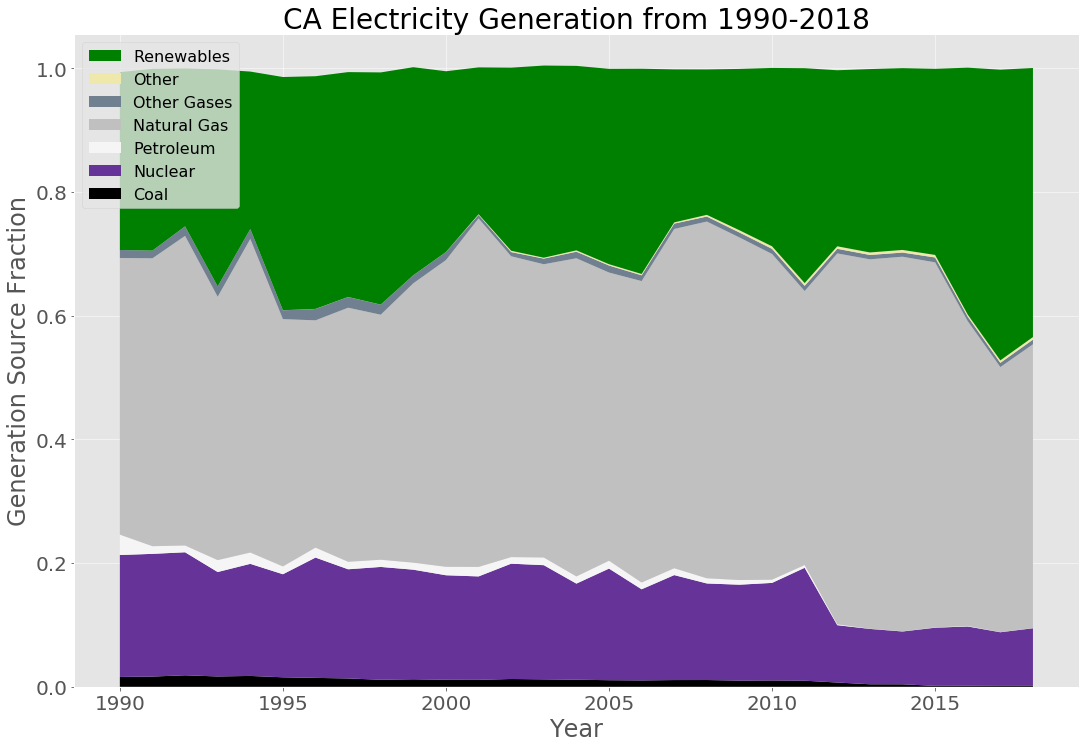

In [130]:
one_stackplot(dfg, "CA", "ren_cols", 18, 12)

**Interpretation**: California is an interesting case, as the state with the most progressive environmental policies for most of the time period analyzed. It's clear California started deploying renewables early, but at relatively small scale. Starting around 2011, solar began growing rapidly, while nuclear declined due to the closure of the San Onofre plant in 2013. Droughts, when gas took the place of hydroelectric, are also discernable. 

## Stackplot Subplots

In [120]:
def subplot_stackplots(dataframe, states, columns):
    nrows = int(np.ceil(len(states)/2))
    height = nrows * 6
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (18,height))
    ax = ax.ravel()
    for i, state in enumerate(states):
        x = list(dataframe['Year'].unique())
        if columns == "gen_cols":
            y = dataframe[dataframe['State'] == state].iloc[:, 2:13].T.values.tolist()
            ax[i].stackplot(x, y, labels=gen_cols, colors=gen_colors)
        else:
            y = dataframe[dataframe['State'] == state].iloc[:, np.r_[2:8,13]].T.values.tolist()        
            ax[i].stackplot(x, y, labels=ren_cols, colors=ren_colors)
        ax[i].set_title("{} Electricity Generation from 1990-2018".format(states[i]), size=20)
        ax[i].set_xlabel("Year", size=18)
        ax[i].set_ylabel("Generation Source Fraction", size=18)
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(reversed(handles), reversed(labels), loc='upper left', prop={'size':8})
        if len(states) % 2 == 1:       #Turn off odd number of subplots
            ax[-1].axis('off')
    plt.tight_layout(h_pad = 3, w_pad = 2)
    plt.grid(True)

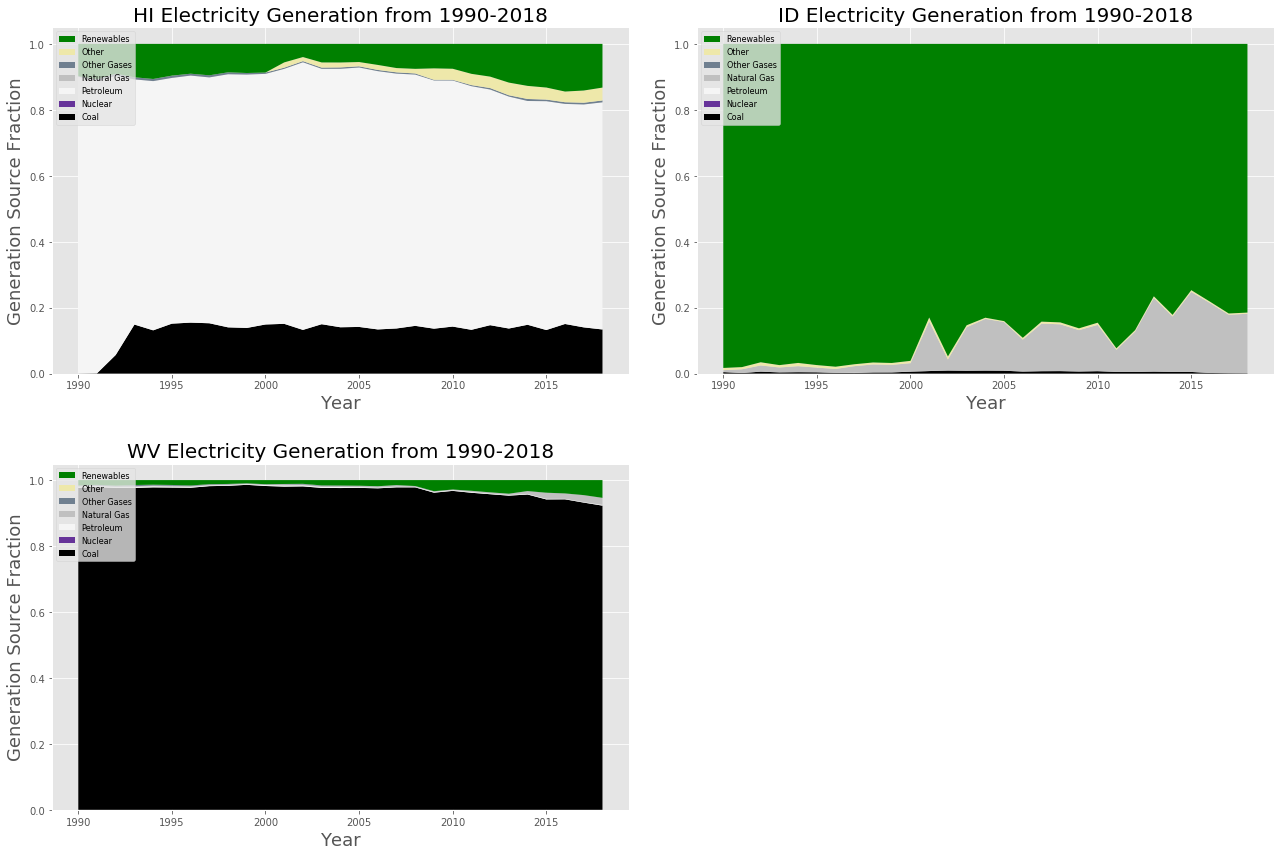

In [121]:
subplot_stackplots(dfg, ['HI', 'ID', 'WV'], "ren_cols")

## Bar Plot - State/Year

In [125]:
def one_barplot(dataframe, state, columns, year, figsize1, figsize2):

    fig, ax = plt.subplots(figsize = (figsize1, figsize2))
    
    if columns == "gen_cols":
        height = dataframe.loc[(dataframe['State'] == state) & (dataframe['Year'] == year)].iloc[:, 2:13].T.squeeze()
        ax.bar(x=gen_cols, height=height, color=gen_colors)
    else:
        height = dataframe.loc[(dataframe['State'] == state) & (dataframe['Year'] == year)].iloc[:, np.r_[2:8,13]].T.squeeze()
        ax.bar(x=ren_cols, height=height, color=ren_colors)    
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper left', prop={'size':16})
    ax.set_title("{} Electricity Generation in {}".format(state, year), fontsize=28)
    ax.set_xlabel("Source", size=24)
    ax.set_ylabel("Generation Source Fraction", size=24)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=12, rotation = 55)

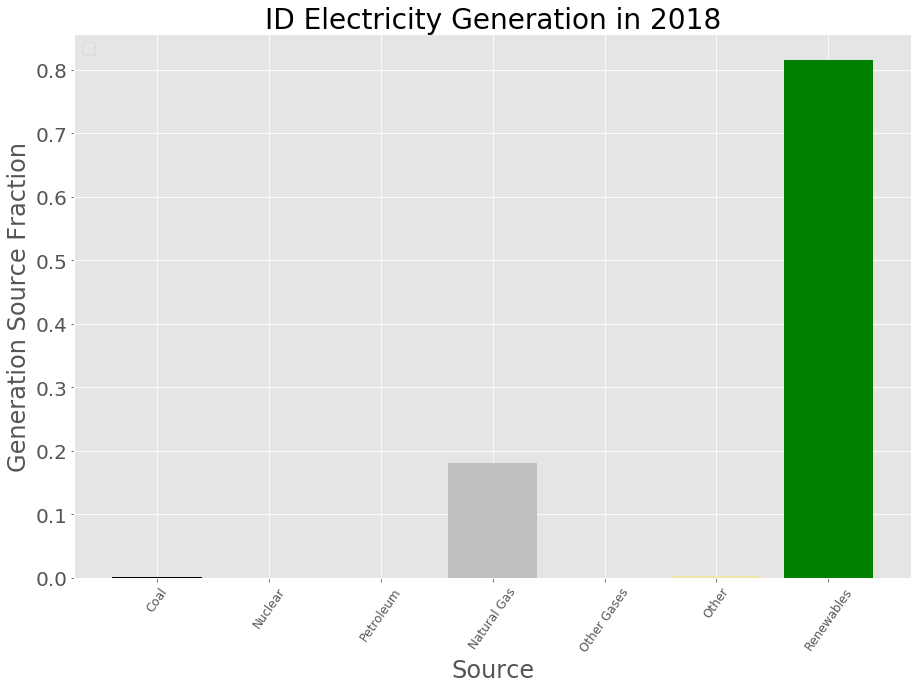

In [126]:
one_barplot(dfg, "ID", "Ren_cols", 2018, 15, 10)

## Bar Plots - Subplots

In [131]:
def subplot_barplots_2by2(dataframe, states, columns, year):
    nrows = int(np.ceil(len(states)/2))
    height = nrows * 7
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (18,height))
    ax = ax.ravel()
    for i, state in enumerate(states):
        
        if columns == "gen_cols":
            barheight = dataframe.loc[(dataframe['State'] == state) & (dataframe['Year'] == year)].iloc[:, 2:13].T.squeeze()
            ax[i].bar(x=gen_cols, height=barheight, color=gen_colors)
            ax[i].set_xticklabels(labels=gen_cols, rotation=45, ha='right')
        else:
            barheight = dataframe.loc[(dataframe['State'] == state) & (dataframe['Year'] == year)].iloc[:, np.r_[2:8,13]].T.squeeze()       
            ax[i].bar(x=ren_cols, height=barheight, color=ren_colors) 
            ax[i].set_xticklabels(labels=ren_cols, rotation=45, ha='right')
    
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(reversed(handles), reversed(labels), loc='upper left', prop={'size':16})
        ax[i].set_title("{} Electricity Generation in {}".format(state, year), fontsize=28)
        ax[i].set_xlabel("Source", size=24)
        ax[i].set_ylabel("Gen. Source Fraction", size=24)
        ax[i].tick_params(labelsize=14)
        plt.tight_layout(h_pad = 3, w_pad = 2)
        if len(states) % 2 == 1:       #Turn off odd number of subplots
            ax[-1].axis('off')

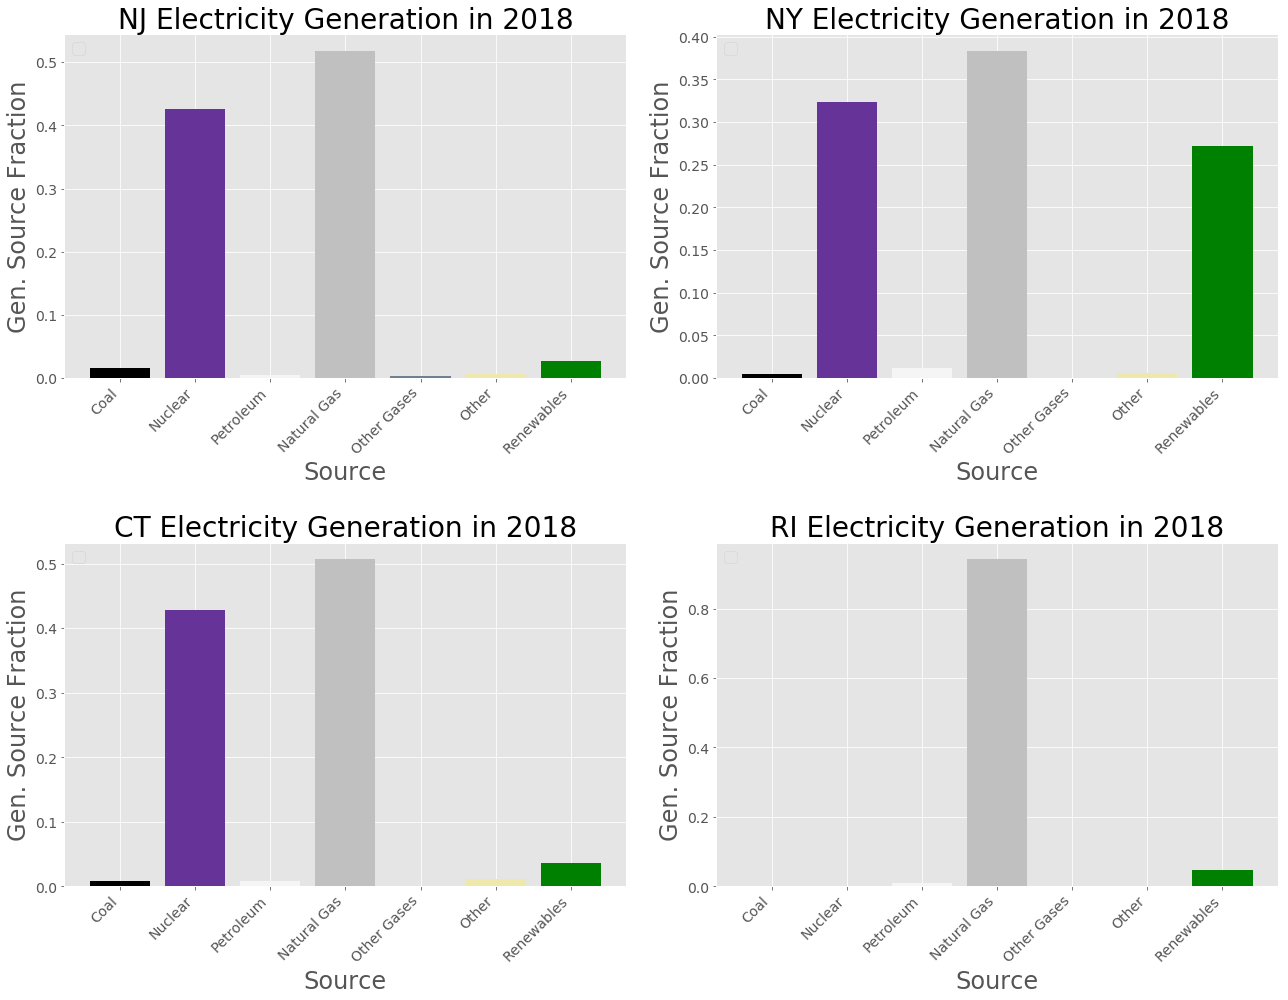

In [132]:
subplot_barplots_2by2(dfg, ['NJ', 'NY', 'CT', 'RI'], "ren_cols", 2018)

# Clustering States by Generation Profile

## K-Means Clustering

In [ ]:
k_list = []
cl_lab_list = []
for i in range(1990, 2019):
    scores = []
    # THIS IS THE NEXT THING I NEED TO FIX - REDUCE THIS TO RENEWABLES NOT THE 5 COLS
    X = dfg[dfg['Year'] == i].drop(columns=['Year', 'Cents_kWh']).set_index('State')
    for k in range(2, 8):
        cl = KMeans(n_clusters=k, random_state = 123)
        cl.fit(X)
        sil = silhouette_score(X, cl.labels_)
        scores.append([i, k, sil])
        score_df = pd.DataFrame(scores)
        score_df.columns = ['year', 'k', 'silhouette']
    best_k = score_df.nlargest(n=1, columns='silhouette')['k'].values[0]
    k_list.extend([best_k]*51)
    cl = KMeans(n_clusters=best_k, random_state = 123)
    cl.fit(X)
    cl_lab_list.extend(cl.labels_)
    
dfg['km_count'] = k_list
dfg['k_cluster'] = cl_lab_list

In [ ]:
dfg.groupby('Year')['km_count'].mean()

In [ ]:
y_2018_4 = list(dfg[(dfg['Year'] == 2018) & (dfg['k_cluster'] == 4)]['State'].values)
subplot_barplots_2by2(dfg, y_2018_4, 2018)

## DBSCAN

In [ ]:
dbscan = DBSCAN(eps=.3, min_samples=2)
dbscan.fit(X)
set(dbscan.labels_)

In [ ]:
db_list = []
db_lab_list = []
for i in range(1990, 2019):
    scores = []
    X = dfg[dfg['Year'] == i].drop(columns=['Year', 'Cents_kWh']).set_index('State')
    for k in range(2, 8):
        cl = KMeans(n_clusters=k, random_state = 123)
        cl.fit(X)
        sil = silhouette_score(X, cl.labels_)
        scores.append([i, k, sil])
        score_df = pd.DataFrame(scores)
        score_df.columns = ['year', 'k', 'silhouette']
    best_k = score_df.nlargest(n=1, columns='silhouette')['k'].values[0]
    k_list.extend([best_k]*51)
    cl = KMeans(n_clusters=best_k, random_state = 123)
    cl.fit(X)
    cl_lab_list.extend(cl.labels_)
    
dfg['km_count'] = k_list
dfg['k_cluster'] = cl_lab_list